Modèle d'analyse de sentiments

In [143]:
import pandas as pd
import seaborn as sns
import pickle

from time import time
from tqdm import tqdm
from pprint import pprint
from os.path import exists
from cleantext import cleantext
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, \
                            accuracy_score, \
                            classification_report, \
                            precision_score, \
                            recall_score

In [144]:
# Paths 

# Dataset from Kaggle with 50000 classified reviews
csv_path = 'data/dataset/imdb_dataset.csv'

# Path to save the dataset with the reviews already cleaned
plk_path = 'data/cleaned_reviews_sentiment.plk'

# Paths for the pipeline with the tokenizer and the classifier model
model_path = 'data/model_sentiment.sav'

In [145]:
reviews_df = pd.read_csv(csv_path)
print(len(reviews_df))
reviews_df.head()

50000


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [146]:
# Replace positive and negative values by 1 and 0 respectively
reviews_df['sentiment'] = [1 if sentiment == 'positive' else 0 for sentiment in reviews_df['sentiment']]
reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [147]:
print(reviews_df.groupby(['sentiment'])['sentiment'].count())
print(f'Valeurs NaN : {reviews_df.isna().sum().sum()}')
print(f'Valeurs nulls : {reviews_df.isnull().sum().sum()}')
print(f'Valeurs différents du 0 et 1 : {len(reviews_df[~reviews_df.sentiment.isin([0, 1])])}')

sentiment
0    25000
1    25000
Name: sentiment, dtype: int64
Valeurs NaN : 0
Valeurs nulls : 0
Valeurs différents du 0 et 1 : 0


<AxesSubplot:ylabel='sentiment'>

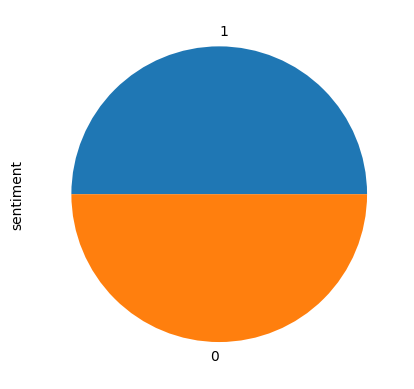

In [148]:
reviews_df['sentiment'].value_counts().plot(kind='pie')

In [149]:
print('Cleaning data from reviews dataset')
reviews_df['cleaned_reviews'] = reviews_df['review'].apply(lambda x : cleantext(x))
reviews_df.drop_duplicates(subset='cleaned_reviews', inplace=True)
print(f'{len(reviews_df)} cleaned reviews :')
print(reviews_df.groupby(['sentiment'])['sentiment'].count())
print(f'Valeurs NaN : {reviews_df.isna().sum().sum()}')
print(f'Valeurs nulls : {reviews_df.isnull().sum().sum()}')
print(f'Valeurs différents du 0 et 1 : {len(reviews_df[~reviews_df.sentiment.isin([0, 1])])}')

Cleaning data from reviews dataset
49574 cleaned reviews :
sentiment
0    24694
1    24880
Name: sentiment, dtype: int64
Valeurs NaN : 0
Valeurs nulls : 0
Valeurs différents du 0 et 1 : 0


<AxesSubplot:ylabel='sentiment'>

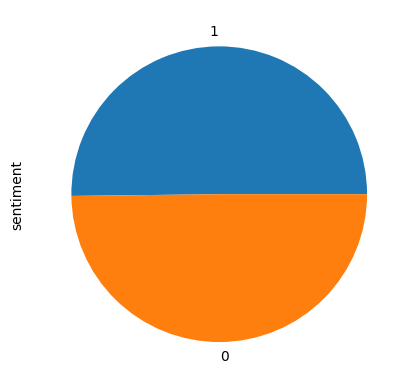

In [150]:
reviews_df['sentiment'].value_counts().plot(kind='pie')

In [151]:
reviews_df.to_pickle(plk_path)
print('Rewiews saved successfully in %s' % plk_path)

Rewiews saved successfully in data/cleaned_reviews_sentiment.plk


In [152]:
# Create a set of unique word along all the 50k reviews
unique_words = set([])

for review in reviews_df['cleaned_reviews']:
    split = review.split()
    for word in split:
        unique_words.add(word)

print('There are %s different words along all the reviews.' %len(unique_words))

There are 70962 different words along all the reviews.


In [153]:
# Count frequency of words along all the reviews and
# create a dictionary with all the words and its frequency
freq_words = dict()
for review in reviews_df['cleaned_reviews']:
    words = review.split()
    for word in words:
        if word in freq_words:
            freq_words[word] += 1
        else:
            freq_words[word] = 1

In [154]:
# A word will be considered as relevant only if it appears at least 50 times along all the 50K reviews
frequent_words = {word:freq for word,freq in freq_words.items() if freq >= 50}

# features will be the quantity of words which will be considered
features = len(frequent_words)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df['cleaned_reviews'].values, reviews_df['sentiment'].values, test_size=0.20, random_state=0)

In [158]:
X_train = X_train.astype(str)
y_train = y_train.astype(str)
X_test = X_test.astype(str)
y_test = y_test.astype(str)

In [159]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(39659,)
(39659,)
(9915,)
(9915,)


# TF-IDF et MultinomialNB

TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

[Differences](https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/)

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

Grid search et fine Tunning

In [76]:
if exists(model_path):
    model = pickle.load(open(model_path, 'rb'))
    print(f'Model {model_path} opened successfully')

else:
    # Define a pipeline combining a text feature extractor with a MultinomialNB Classifier
    pipeline = Pipeline(
        [
            ('tfidf', TfidfVectorizer()),
            ('clf', MultinomialNB()),
        ]
    )

    # Parameters to use for grid search
    parameters = {
        'tfidf__norm': ['l1', 'l2'],
        'tfidf__min_df' : [1, 2, 3], # Ignore terms that have a document frequency strictly lower than the given threshold 
        'tfidf__use_idf': [True, False],
        'tfidf__max_features': [None, int(len(unique_words)*0.9), int(len(unique_words)*0.75), int(len(unique_words)*0.5)], # Size of the vocabulary
        'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'clf__alpha': [0, 1.0],
        'clf__fit_prior': [True, False],
    }

    # Find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, )

    print('Performing grid search...')
    print('Pipeline: ', [name for name, _ in pipeline.steps])
    print('Parameters: ')
    pprint(parameters)
    t0 = time()
    model = grid_search.fit(list(X_train), list(y_train))
    print('Done in %0.3fs' % (time() - t0))
    print()

    print('Best score: %0.3f' % grid_search.best_score_)
    print('Best parameters set: ')
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    
    pickle.dump(model, open(model_path, 'wb'))
    print(f'Model {model_path} created successfully')
    
tfidf = model.best_estimator_.named_steps['tfidf']
clf = model.best_estimator_.named_steps['clf']

Performing grid search...
Pipeline:  ['tfidf', 'clf']
Parameters: 
{'clf__alpha': [0, 1.0],
 'clf__fit_prior': [True, False],
 'tfidf__max_features': [None, 63865, 53221, 35481],
 'tfidf__min_df': [1, 2, 3],
 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'tfidf__norm': ['l1', 'l2'],
 'tfidf__use_idf': [True, False]}
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Done in 12135.589s

Best score: 0.885
Best parameters set: 
	clf__alpha: 1.0
	clf__fit_prior: False
	tfidf__max_features: None
	tfidf__min_df: 2
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l2'
	tfidf__use_idf: True


Résultats Gridsearch

Best score: 0.885

Best parameters set:<br>
* clf__alpha: 1.0<br>
* clf__fit_prior: False<br>
* tfidf__max_features: None<br>
* tfidf__min_df: 2<br>
* tfidf__ngram_range: (1, 2)<br>
* tfidf__norm: 'l2'<br>
* tfidf__use_idf: True<br>

(202m 15.6s)

Making a New Prediction

In [163]:
#new_review = 'I Hate this movie so much. It\'s ok.'
new_review = 'This is the best movie I\'ve ever seen'
new_corpus = [cleantext(new_review)]

x_pred = model.predict(new_corpus)
print('Positive' if x_pred == '1' else 'Negative')

Positive
